## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

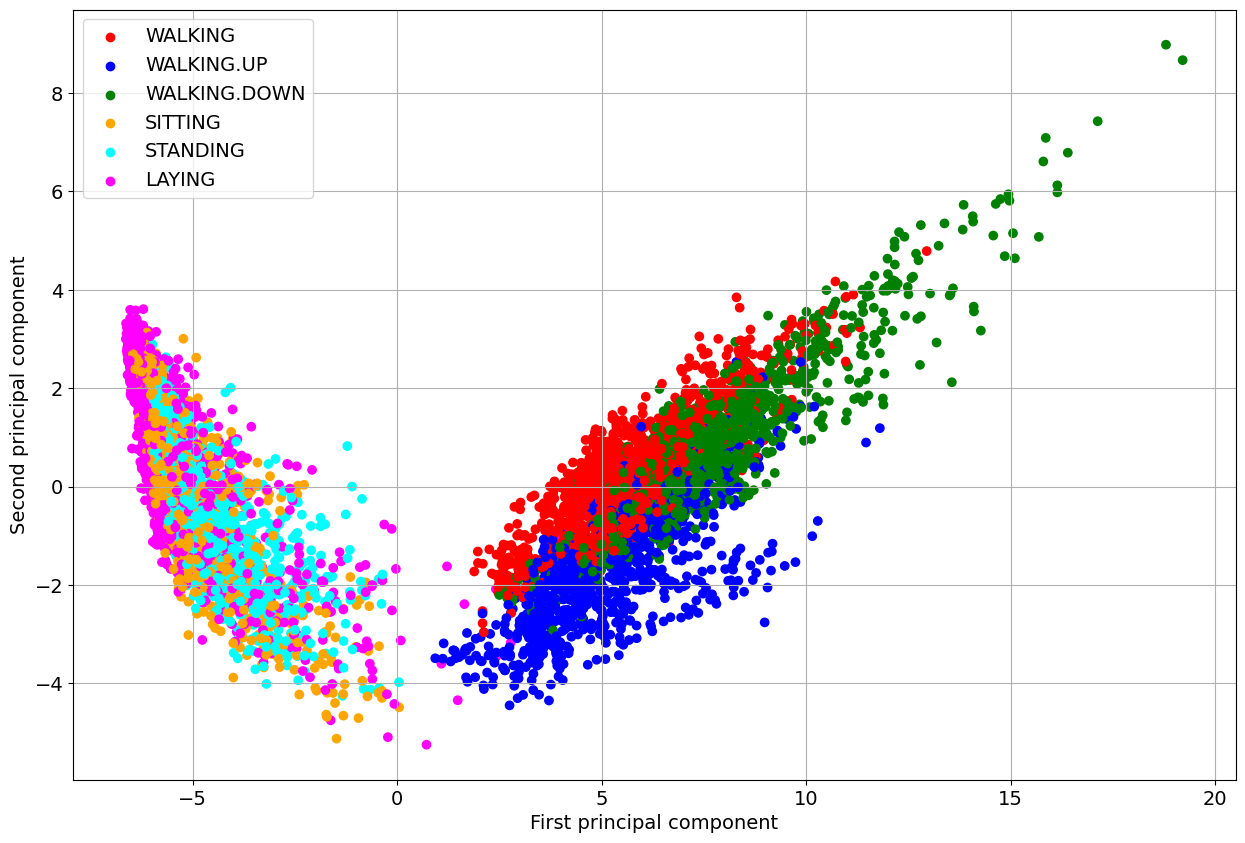

In [4]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [5]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [7]:
X_train.shape

(7352, 128, 9)

In [8]:
X_train.transpose(0, 2, 1).shape

(7352, 9, 128)

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [22]:
import torch 
from torch import nn 
import torch.functional as F
from collections.abc import Callable, Iterable
from tqdm import tqdm
import time
from IPython.display import Markdown, clear_output, display

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [24]:
def get_batches(X, y, batch_size, train: bool=False):
    indices = np.arange(X.shape[0])
    if train:
        np.random.shuffle(indices)
    
    for start_idx in range(0, X.shape[0], batch_size):
        yield X[start_idx:start_idx+batch_size], y[start_idx:start_idx+batch_size]


def plot_epoch(history: list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    ax[0].plot(train_loss, label='train_loss', color="red")
    ax[0].plot(val_loss, label='val_loss', color="blue")
    ax[1].plot(train_acc, label='train_acc', color="green")
    ax[1].plot(val_acc, label='val_acc', color="lime")
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
 
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")

    plt.show()

In [25]:
def fit_epoch(model, tepoch, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()

    for inputs, labels in tepoch:
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1).cpu().detach().numpy()
        running_loss += loss.item() * inputs.shape[0]
        running_corrects += np.sum(preds == labels.cpu().numpy())
        processed_data += inputs.shape[0]
        tepoch.set_postfix(loss=loss.item(),
                accuracy=str(100. * running_corrects / processed_data)[:4])
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1).cpu().detach().numpy()


            running_loss += loss.item() * inputs.shape[0]
            running_corrects += np.sum(preds == labels.cpu().numpy())
            processed_size += inputs.shape[0]
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [26]:
def train_model(model: nn.Module, X_train: Iterable, 
                y_train: Iterable, X_val: Iterable,
                y_val: Iterable, optimizer: Callable,
                criterion: Callable, batch_size:int = 128,
                show: bool=True, n_epochs: int=20, log_time: bool=True
                ):
                
    history = []
    times = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    start_time = time.time() if log_time else None
    for epoch in range(n_epochs):
        batches = get_batches(X_train, y_train, train=True, batch_size=batch_size)

        # train step
        model.train()
        with tqdm(batches, unit="batch", total=len(X_train) // batch_size) as tepoch:
            tepoch.set_description("Epoch {} / {}".format(epoch + 1, n_epochs))
            train_loss, train_acc = fit_epoch(model, tepoch, criterion, optimizer)

        # validation step
        val_batches = get_batches(X_val, y_val, batch_size)
        model.eval()
        val_loss, val_acc = eval_epoch(model, val_batches, criterion, optimizer)
        history.append((train_loss, train_acc, val_loss, val_acc))
        if start_time:
            times.append(time.time() - start_time)
        if show:
            clear_output(wait=True)
            plot_epoch(history)
        tepoch.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    if log_time:
        return history, times
    return history

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train_with_engineered_features.shape, y_train.shape

((7352, 561), (7352, 1))

In [29]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(torch.tensor(X_train).transpose(1, 2), torch.tensor(y_train).flatten().long(), test_size=0.2)

In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=18, kernel_size=1),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=1),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=36, out_channels=72, kernel_size=1),
            nn.MaxPool1d(kernel_size=4),
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(num_features=144),
            nn.Linear(144, n_classes),
            nn.LogSoftmax(dim=-1)
        )
        
    def forward(self, X):
        return self.sequential(X)

In [18]:
model = NeuralNetwork().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=[0.5, 0.5])

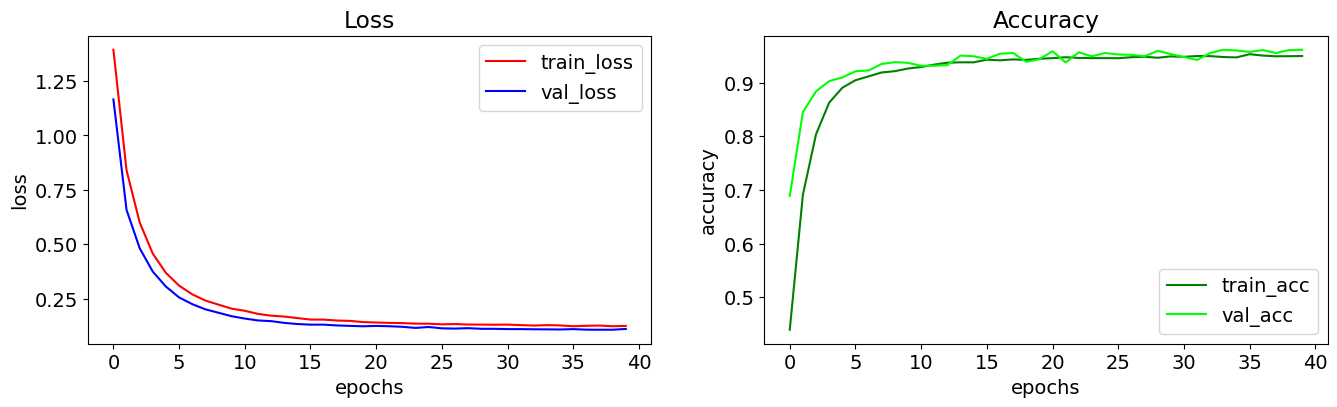


Epoch 040 train_loss: 0.1246     val_loss 0.1106 train_acc 0.9495 val_acc 0.9613


In [19]:
history = train_model(model, X_train_split, y_train_split, X_val_split, y_val_split, optimizer, criterion, n_epochs=40, log_time=False)

In [20]:
from sklearn.metrics import accuracy_score
def predict(model: nn.Module, X_test: Iterable, y_test: Iterable, scoring: bool=True):
    model.eval()
    predictions = []
    accuracies = []
    test_loader = get_batches(X_test, y_test, batch_size=128)
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1).cpu().detach().numpy()
        predictions += list(preds)
        if scoring:
            accuracies.append(accuracy_score(preds, labels.cpu().numpy()))
    if scoring:
        print("Accuracy score: ", np.mean(accuracies))
    return predictions

In [21]:
predict(model, torch.tensor(X_test).transpose(1, 2), torch.tensor(y_test).flatten().long());

Accuracy score:  0.9065755208333334


Keeping in mind the sequential nature of the dataset, let's try the rnn architecture.

In [31]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(torch.tensor(X_train), torch.tensor(y_train).flatten().long(), test_size=0.2)

In [52]:
class LSTMNetrork(nn.Module):
    def __init__(self):
        super(LSTMNetrork, self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=n_hidden, batch_first=True)
        self.linear = nn.Linear(n_hidden, n_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, X):
        _, (_, hidden_state) = self.lstm(X)
        logits = self.linear(hidden_state.squeeze())
        return self.log_softmax(logits)

In [55]:
model = LSTMNetrork().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, betas=[0.5, 0.5])

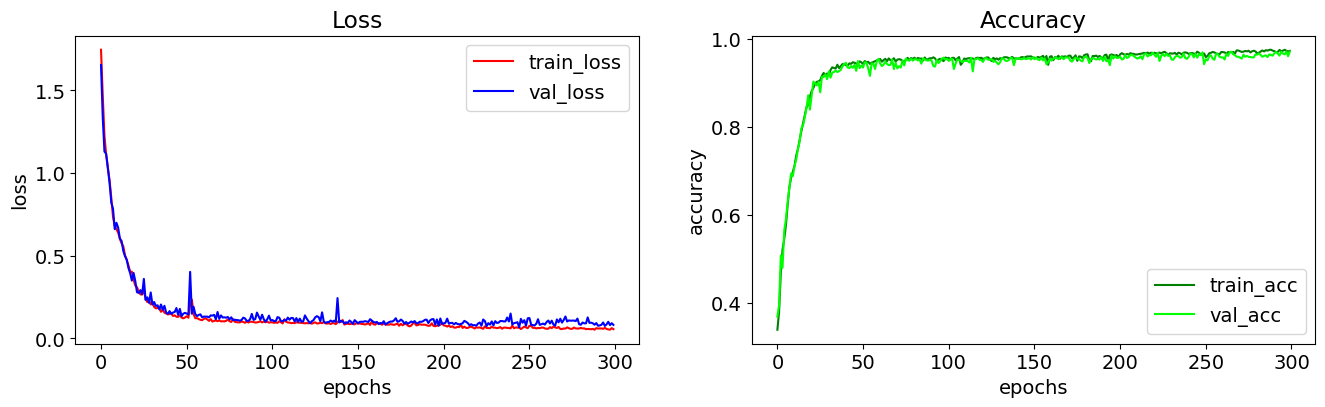


Epoch 300 train_loss: 0.0566     val_loss 0.0824 train_acc 0.9733 val_acc 0.9714


In [56]:
history = train_model(model, X_train_split, y_train_split, X_val_split, y_val_split, optimizer, criterion, n_epochs=300, batch_size=512, log_time=False)

In [57]:
predict(model, torch.tensor(X_test), torch.tensor(y_test).flatten().long());

Accuracy score:  0.8929036458333334


Let's perfom some normalization stuff

In [58]:
class LSTMWithNormalizationNetrork(nn.Module):
    def __init__(self):
        super(LSTMWithNormalizationNetrork, self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=n_hidden, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(num_features=n_hidden)
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(n_hidden, n_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, X):
        _, (_, hidden_state) = self.lstm(X)
        logits = self.linear(self.dropout(self.batchnorm(hidden_state.squeeze())))
        return self.log_softmax(logits)

In [59]:
model = LSTMWithNormalizationNetrork().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

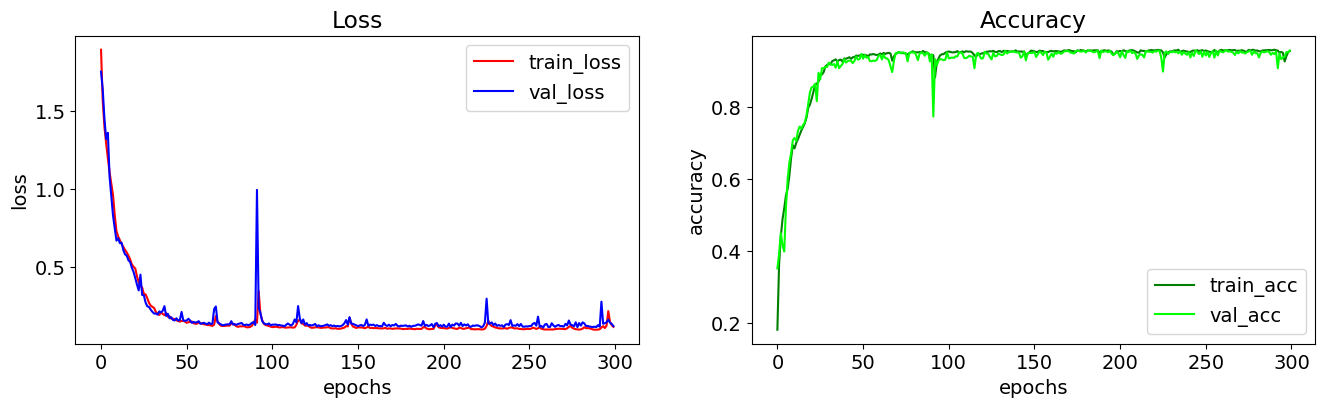


Epoch 300 train_loss: 0.1126     val_loss 0.1176 train_acc 0.9568 val_acc 0.9579


In [60]:
train_model(model, X_train_split, y_train_split, X_val_split, y_val_split, optimizer, criterion, n_epochs=300, batch_size=512, log_time=False);

In [61]:
predict(model, torch.tensor(X_test), torch.tensor(y_test).flatten().long());

Accuracy score:  0.9248046875


Quite strange behavior during the learning step but the best results for every other reviewed model. At first I tried the common `CNN` architecture. It required some preprocessing transformations to actually fit the convolution network. After that I've tried `LSTM` network. Firstly merely trained usual lstm with predefined hidden_size in the notebook, obtained good validation and train losses and metrics with compatible with CNN score results. After, I added `BatchNorm` and `DropOut`. It slightly increased the running time and gave the best results in comparison with other models.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# Your experiments here